In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150
import seaborn as sns
from Bio import SeqIO, Seq
import scipy.stats as st
import timeit

import glob, os, yaml, subprocess, itertools, sparse, vcf
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from statsmodels.distributions.empirical_distribution import ECDF

who_variants = pd.read_csv("/n/data1/hms/dbmi/farhat/Sanjana/MIC_data/WHO_resistance_variants_all.csv")
pd.set_option('display.float_format', lambda x: '%.4f' % x)

# Rifampicin

In [2]:
rif_res = pd.read_pickle("/n/data1/hms/dbmi/farhat/ye12/who/analysis/Drugs/Rifampicin/tiers=1_drop_HET/model_analysis.pkl")

# number of principal components with positive coefficients (OR > 1)
print(len(rif_res.query("coef > 0").loc[rif_res.query("coef > 0").orig_variant.str.contains('PC')]))

1


In [3]:
rif_res.query("coef > 0 & pval < 0.05")[["orig_variant", "OR_Lower_CI", "Odds_Ratio", "OR_Upper_CI", "PPV_Lower_CI", "PPV", "PPV_Upper_CI", "pval", "BH_pval", "Bonferroni_pval", "confidence_WHO_2021"]]

,orig_variant,OR_Lower_CI,Odds_Ratio,OR_Upper_CI,PPV_Lower_CI,PPV,PPV_Upper_CI,pval,BH_pval,Bonferroni_pval,confidence_WHO_2021
0,rpoB_p.Ser450Leu,19.5081,22.0246,25.3000,0.9847,0.9888,0.9927,0.0000,0.0000,0.0000,1) Assoc w R
1,rpoB_p.Asp435Val,3.1741,3.5438,4.0448,0.9659,0.9808,0.9938,0.0000,0.0000,0.0000,1) Assoc w R
2,rpoB_p.His445Tyr,2.3444,2.5928,2.8423,0.9662,0.9869,1.0000,0.0000,0.0000,0.0000,1) Assoc w R
3,rpoB_p.His445Asp,2.2848,2.5182,2.9203,0.9543,0.9778,0.9947,0.0000,0.0000,0.0000,1) Assoc w R
4,rpoB_p.Ser450Phe,1.7632,1.9538,2.1613,0.9565,0.9872,1.0000,0.0000,0.0000,0.0000,1) Assoc w R
...,...,...,...,...,...,...,...,...,...,...,...
271,rpoB_p.Glu284Gly,0.9999,1.0172,1.0268,1.0000,1.0000,1.0000,0.0449,0.2016,1.0000,3) Uncertain significance
272,rpoB_p.Ala527Thr,1.0000,1.0171,1.0277,1.0000,1.0000,1.0000,0.0436,0.1995,1.0000,NaN
274,rpoB_p.Asn501Lys,0.9999,1.0148,1.0205,1.0000,1.0000,1.0000,0.0338,0.2103,1.0000,3) Uncertain significance
275,rpoB_p.Phe503Val,0.9999,1.0148,1.0205,1.0000,1.0000,1.0000,0.0338,0.2103,1.0000,3) Uncertain significance


In [4]:
who_variants.loc[(who_variants.drug == 'RIF') & (who_variants.confidence.str.contains("|".join(["1", "2"])))]

,Unnamed: 0,drug,genome_index,confidence,gene,variant
14365,14283,RIF,"761154,761155",1) Assoc w R,rpoB,rpoB_S450L
14366,14284,RIF,761155,1) Assoc w R,rpoB,rpoB_S450L
14367,14285,RIF,761110,1) Assoc w R,rpoB,rpoB_D435V
14368,14286,RIF,761139,1) Assoc w R,rpoB,rpoB_H445Y
14369,14287,RIF,761139,1) Assoc w R,rpoB,rpoB_H445D
...,...,...,...,...,...,...
14508,14426,RIF,761115,2) Assoc w R - Interim,rpoB,rpoB_N437Y
14509,14427,RIF,761122,2) Assoc w R - Interim,rpoB,rpoB_P439L
14510,14428,RIF,"761112,761114",2) Assoc w R - Interim,rpoB,rpoB_Q436N
14511,14429,RIF,"761085,761086",2) Assoc w R - Interim,rpoB,rpoB_T427G


# Amikacin

In [5]:
ami_res = pd.read_pickle("/n/data1/hms/dbmi/farhat/ye12/who/analysis/Drugs/Amikacin/tiers=1_2_drop_HET/model_analysis.pkl")

# number of principal components with positive coefficients (OR > 1)
print(len(ami_res.query("coef > 0").loc[ami_res.query("coef > 0").orig_variant.str.contains('PC')]))

1


In [7]:
who_variants.loc[(who_variants.drug == 'AMI') & (who_variants.confidence.str.contains("|".join(["1", "2"])))]

,Unnamed: 0,drug,genome_index,confidence,gene,variant
1634,1,AMI,1473246,1) Assoc w R,rrs,rrs_a1401g
1635,2,AMI,2715346,1) Assoc w R,eis,eis_c-14t
1636,3,AMI,1473329,2) Assoc w R - Interim,rrs,rrs_g1484t
1637,4,AMI,1473247,2) Assoc w R - Interim,rrs,rrs_c1402t


# Moxifloxacin

In [43]:
moxi_res = pd.read_pickle("/n/data1/hms/dbmi/farhat/ye12/who/analysis/Drugs/Moxifloxacin/tiers=1_drop_HET/model_analysis.pkl")

# number of principal components with positive coefficients (OR > 1)
print(len(moxi_res.query("coef > 0").loc[moxi_res.query("coef > 0").orig_variant.str.contains('PC')]))

moxi_res_noPopCorr = pd.read_pickle("/n/data1/hms/dbmi/farhat/ye12/who/analysis/Drugs/Moxifloxacin/tiers=1_drop_HET_noPopCorr/model_analysis.pkl")

# variants in moxi_res that are not in the results without population structure correction
print(set(moxi_res.orig_variant)-set(moxi_res_noPopCorr.orig_variant))

1
{'PC4', 'PC3', 'PC1', 'PC0', 'PC2'}


In [44]:
moxi_res_noPopCorr.query("(OR_LB > 1 & OR_UB > 1)").columns

Index(['orig_variant', 'coef', 'coef_LB', 'coef_UB', 'pval', 'BH_pval',
       'Bonferroni_pval', 'genome_index', 'confidence_WHO_2021', 'Odds_Ratio',
       'OR_LB', 'OR_UB', 'Num_Isolates', 'TP', 'FP', 'TN', 'FN', 'PPV', 'Sens',
       'Spec', 'LR+', 'LR-', 'PPV_LB', 'PPV_UB', 'Sens_LB', 'Sens_UB',
       'Spec_LB', 'Spec_UB', 'LR+_LB', 'LR+_UB', 'LR-_LB', 'LR-_UB'],
      dtype='object')

In [45]:
def compare_models_population_structure_correction(res_df, res_df_noPopCorr, alpha, diff_thresh):
    '''
    Comparison to determine if population structure determination is necessary. Things to compare:
    
    1. Do all the same variants have non-zero coefficients (the returned dataframes are only non-zero coefficients)?
    2. Compute Pearson correlation between coefficients.
    3. Do features have p-values that are on the same side of the threshold (0.05 or 0.01)?
    '''
    
    plot_df = res_df[["orig_variant", "coef", "pval", "coef_LB", "coef_UB"]].merge(res_df_noPopCorr[["orig_variant", "coef", "pval", "coef_LB", "coef_UB"]], on="orig_variant")    
    
    # coefficient without population structure correction - coefficient with correction
    plot_df["diff"] = plot_df["coef_y"] - plot_df["coef_x"]
    plot_df["norm_diff"] = plot_df["diff"] / plot_df["coef_x"]
    #plot_df = plot_df.query("norm_diff <= 1 & norm_diff >= -1")

    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    sns.scatterplot(data=plot_df, x="coef_x", y="coef_y", ax=ax[0])
    ax[0].set_xlabel("Coef, Population Structure Correction")
    ax[0].set_ylabel("Coef, No Correction")
    ax[0].set_title(f"Pearson R: {np.round(st.pearsonr(plot_df['coef_x'], plot_df['coef_y'])[0], 4)}")

    sns.scatterplot(data=plot_df, x="coef_x", y="norm_diff", ax=ax[1])
    ax[1].set_xlabel("Coef, Population Structure Correction")
    ax[1].set_ylabel("Norm. Difference")

    sns.despine()
    plt.show()
    
    # get features whose coefficients differ by more than a 100% difference
    # (difference between coefficients without and with correction is greater than the coefficient with population structure correction
    large_diff = plot_df.query("norm_diff >= @diff_thresh | norm_diff <= -@diff_thresh")
    
    # get the number of features with confidence intervals that lie on different sides of 0
    print(f'{len(plot_df.query("coef_LB_x > 0 & coef_UB_x > 0 & coef_LB_y < 0 & coef_UB_y < 0"))} features have confidence intervals on different sides of 0')
    print(f'{len(large_diff.query("coef_LB_x > 0 & coef_UB_x > 0 & coef_LB_y < 0 & coef_UB_y < 0"))} features with very different coefficients have confidence intervals on different sides of 0')
    

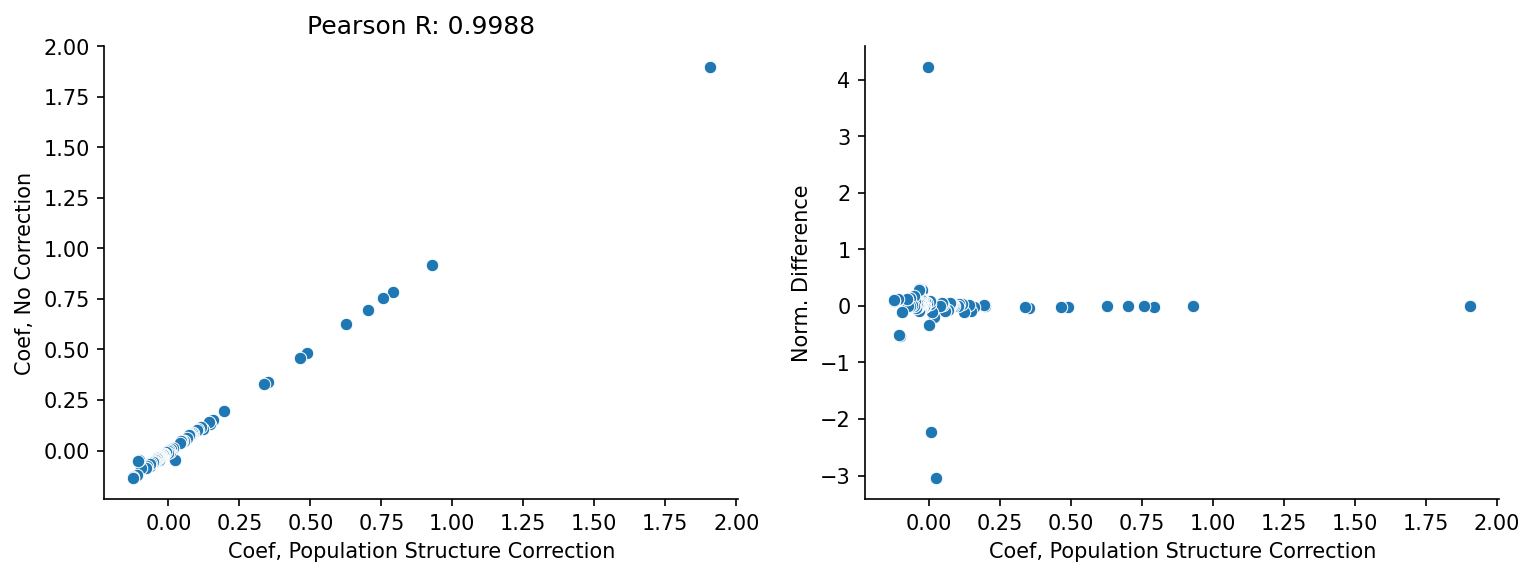

0 features have confidence intervals on different sides of 0
0 features with very different coefficients have confidence intervals on different sides of 0


In [46]:
compare_models_population_structure_correction(moxi_res, moxi_res_noPopCorr, 0.05, 0)

In [8]:
#moxi_res.query("coef > 0 & pval < 0.05")[["orig_variant", "OR_Lower_CI", "Odds_Ratio", "OR_Upper_CI", "PPV_Lower_CI", "PPV", "PPV_Upper_CI", "pval", "BH_pval", "Bonferroni_pval", "confidence_WHO_2021"]]

In [9]:
#who_variants.loc[(who_variants.drug == 'MXF') & (who_variants.confidence.str.contains("|".join(["1", "2"])))]

# Pyrazinamide

In [11]:
pza_res = pd.read_pickle("/n/data1/hms/dbmi/farhat/ye12/who/analysis/Drugs/Pyrazinamide/tiers=1_drop_HET/model_analysis.pkl")

# number of principal components with positive coefficients (OR > 1)
print(len(pza_res.query("coef > 0").loc[pza_res.query("coef > 0").orig_variant.str.contains('PC')]))

4


In [12]:
pza_res.head(20)

,orig_variant,coef,Lower_CI,Upper_CI,pval,BH_pval,Bonferroni_pval,genome_index,confidence_WHO_2021,Odds_Ratio,OR_Lower_CI,OR_Upper_CI,PPV,NPV,PPV_Lower_CI,PPV_Upper_CI,NPV_Lower_CI,NPV_Upper_CI
0,pncA_p.His57Asp,0.5623,0.5298,0.5966,0.0000,0.0000,0.0000,2289073,1) Assoc w R,1.7546,1.6986,1.8160,0.9871,0.8505,0.9673,1.0000,0.8451,0.8554
1,PC0,0.4427,0.3908,0.5091,0.0000,0.0000,0.0000,NaN,NaN,1.5569,1.4782,1.6638,NaN,NaN,NaN,NaN,NaN,NaN
2,pncA_c.-11A>G,0.3859,0.3450,0.4340,0.0000,0.0000,0.0000,2289252,1) Assoc w R,1.4709,1.4120,1.5434,0.9429,0.8478,0.8911,0.9810,0.8425,0.8527
3,pncA_p.His51Asp,0.3159,0.2797,0.3474,0.0000,0.0000,0.0000,2289091,1) Assoc w R,1.3714,1.3228,1.4154,0.9792,0.8453,0.9273,1.0000,0.8396,0.8504
4,pncA_p.Gln10Pro,0.2779,0.2386,0.3311,0.0000,0.0000,0.0000,2289213,1) Assoc w R,1.3204,1.2695,1.3925,0.9508,0.8459,0.8906,1.0000,0.8403,0.8510
5,pncA_p.Gln141Pro,0.2626,0.2222,0.3177,0.0000,0.0000,0.0000,2288820,1) Assoc w R,1.3003,1.2489,1.3739,0.9474,0.8457,0.8776,1.0000,0.8402,0.8507
6,pncA_p.Leu172Pro,0.2626,0.2442,0.2774,0.0000,0.0000,0.0000,2288727,1) Assoc w R,1.3003,1.2766,1.3196,1.0000,0.8445,1.0000,1.0000,0.8390,0.8495
7,pncA_p.Thr76Pro,0.2502,0.2126,0.3040,0.0000,0.0000,0.0000,2289016,1) Assoc w R,1.2843,1.2369,1.3552,0.9348,0.8451,0.8541,1.0000,0.8394,0.8502
8,pncA_p.Asp49Gly,0.2280,0.1919,0.2786,0.0000,0.0000,0.0000,2289096,1) Assoc w R,1.2561,1.2115,1.3212,0.9167,0.8446,0.8205,1.0000,0.8392,0.8496
9,pncA_p.His57Arg,0.2124,0.1742,0.2515,0.0000,0.0000,0.0000,2289072,1) Assoc w R,1.2366,1.1903,1.2859,0.9677,0.8445,0.8889,1.0000,0.8388,0.8495


In [13]:
who_variants.loc[(who_variants.drug == 'PZA') & (who_variants.confidence.str.contains("|".join(["1"])))]

,Unnamed: 0,drug,genome_index,confidence,gene,variant
13310,13121,PZA,2289073,1) Assoc w R,pncA,pncA_H57D
13311,13122,PZA,2289252,1) Assoc w R,pncA,pncA_a-11g
13312,13123,PZA,2289213,1) Assoc w R,pncA,pncA_Q10P
13313,13124,PZA,2289091,1) Assoc w R,pncA,pncA_H51D
13314,13125,PZA,2289016,1) Assoc w R,pncA,pncA_T76P
...,...,...,...,...,...,...
13418,13229,PZA,2288777,1) Assoc w R,pncA,pncA_465_ins_1_c_ca
13419,13230,PZA,2288955,1) Assoc w R,pncA,pncA_K96R
13420,13231,PZA,2289222,1) Assoc w R,pncA,pncA_V7A
13421,13232,PZA,2288885,1) Assoc w R,pncA,pncA_W119C
